In [143]:

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from decomposition import DecompositionLayer
torch.set_num_threads(9)

class MyDataset(TensorDataset):
    def __init__(self, data, window):
        self.data = data
        self.window = window

    def __getitem__(self, index):
        x = self.data[index:index+self.window]
        return x

    def __len__(self):
        return len(self.data) - self.window

In [144]:
input_size = 50

learning_rate = 0.0001

In [145]:
class DecompositionLayer(nn.Module):
    """
    Returns the trend and the seasonal parts of the time series.
    """

    def __init__(self, kernel_size):
        super().__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=1, padding=0) # moving average 

    def forward(self, x):
        """Input shape: Batch x Time x EMBED_DIM"""
        # padding on the both ends of time series
        num_of_pads = (self.kernel_size - 1) // 2
        front = x[:, 0:1, :].repeat(1, num_of_pads, 1)
        end = x[:, -1:, :].repeat(1, num_of_pads, 1)
        x_padded = torch.cat([front, x, end], dim=1)

        # calculate the trend and seasonal part of the series
        x_trend = self.avg(x_padded.permute(0, 2, 1)).permute(0, 2, 1)
        #print(x_trend.shape)
        x_seasonal = x - x_trend
        return x_seasonal, x_trend

In [146]:
class DLinearModel(nn.Module):
    def __init__(self, input_size):
        super(DLinearModel, self).__init__()
        self.linear_seasonal = nn.Linear(10, 1)
        self.linear_trend = nn.Linear(10, 1)
        self.decomposition = DecompositionLayer(5)
        self.bias = nn.Parameter(torch.zeros(1))
        
    def forward(self, context):
        seasonal, trend = self.decomposition(context)
        #print(seasonal, trend)
        seasonal_output = self.linear_seasonal(seasonal.reshape(1, 1, -1))
        trend_output = self.linear_trend(trend.reshape(1, 1, -1))
        
        return seasonal_output + trend_output


def train_model(model, dataloader, criterion, optimizer, num_epochs=100):
    for epoch in range(num_epochs):
        for X in dataloader:
            optimizer.zero_grad()
            output = model.forward(X)
            loss = criterion(output, X)
            loss.backward()
            optimizer.step()


In [147]:
data_size  = 2000
step = 3
data = pd.read_csv('ETTh1.csv')  
X = torch.tensor(data['HUFL'].values[:data_size:step], dtype=torch.float32).view(-1, 1)
x = pd.read_csv("ETTh1.csv").HUFL

In [148]:
model = DLinearModel(input_size)
criterion = nn.L1Loss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate)


window_size = 10  # Размер окна для rolling window forecasting
#переписать

dataset = MyDataset(X, window_size)

#print(x.rolling(window_size))

dataloader = DataLoader(dataset)#, shuffle=True)

In [149]:
len(dataloader)

657

In [150]:
train_model(model, dataloader, criterion, optimizer)


c:\Users\evgen\miniconda3\envs\MyDLinear\Lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([1, 10, 1])) that is different to the input size (torch.Size([1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


In [151]:
torch.save(model.state_dict(), "test_model_v4")

In [152]:
model.load_state_dict(torch.load("test_model_v4"))
model.eval()

DLinearModel(
  (linear_seasonal): Linear(in_features=10, out_features=1, bias=True)
  (linear_trend): Linear(in_features=10, out_features=1, bias=True)
  (decomposition): DecompositionLayer(
    (avg): AvgPool1d(kernel_size=(5,), stride=(1,), padding=(0,))
  )
)

In [153]:
model.parameters

<bound method Module.parameters of DLinearModel(
  (linear_seasonal): Linear(in_features=10, out_features=1, bias=True)
  (linear_trend): Linear(in_features=10, out_features=1, bias=True)
  (decomposition): DecompositionLayer(
    (avg): AvgPool1d(kernel_size=(5,), stride=(1,), padding=(0,))
  )
)>

In [154]:
def predict_future_values(model, X_f, window_size, m):
    #predicted_values = initial_values.clone().detach().view(-1).tolist()
    predicted_values = []
    
    for i in range(m):
        
        
        #проверить что модель принимает нужный набор значений
        #last_X = torch.tensor([predicted_values[-1]], dtype=torch.float32).view(-1, 1)
        # last_X_t = torch.tensor([predicted_values[-1]], dtype=torch.float32).view(-1, 1)
        
        prediction = model(X_f)

        
        predicted_values.append(prediction.tolist()[-1][-1][-1])
        if(window_size > i):
            
            X_f = torch.tensor(data['HUFL'].values[data_size-window_size+i+1::step] + predicted_values, dtype=torch.float32).reshape(1, 1, -1)
        else:
            X_f = torch.tensor(predicted_values, dtype=torch.float32).reshape(1, 1, -1)
            
        

    return predicted_values

In [163]:
initial_values = torch.cat([X[-input_size:]]).reshape(1, 1, -1)
m = 1000 #на сколько шагов предсказать
pred  = 20
X_f = torch.tensor(data['HUFL'].values[data_size-pred:data_size], dtype=torch.float32).view(-1, 1)
print(X_f)
dataset_f = MyDataset(X_f, pred)
print(dataset_f.data)
#print(x.rolling(window_size))

dataloader_f = DataLoader(dataset_f)#, shuffle=True)

X_f


tensor([[ 5.3580],
        [ 5.4250],
        [ 6.2290],
        [ 6.6310],
        [ 5.9610],
        [ 6.6980],
        [ 6.2290],
        [ 6.4300],
        [ 5.8940],
        [ 5.4250],
        [ 6.5640],
        [ 8.2390],
        [11.8550],
        [10.7170],
        [11.7880],
        [11.8550],
        [10.1810],
        [13.3290],
        [13.5970],
        [11.5880]])
tensor([[ 5.3580],
        [ 5.4250],
        [ 6.2290],
        [ 6.6310],
        [ 5.9610],
        [ 6.6980],
        [ 6.2290],
        [ 6.4300],
        [ 5.8940],
        [ 5.4250],
        [ 6.5640],
        [ 8.2390],
        [11.8550],
        [10.7170],
        [11.7880],
        [11.8550],
        [10.1810],
        [13.3290],
        [13.5970],
        [11.5880]])


tensor([[ 5.3580],
        [ 5.4250],
        [ 6.2290],
        [ 6.6310],
        [ 5.9610],
        [ 6.6980],
        [ 6.2290],
        [ 6.4300],
        [ 5.8940],
        [ 5.4250],
        [ 6.5640],
        [ 8.2390],
        [11.8550],
        [10.7170],
        [11.7880],
        [11.8550],
        [10.1810],
        [13.3290],
        [13.5970],
        [11.5880]])

In [164]:
X_t = X_f.tolist()
X_t

[[5.357999801635742],
 [5.425000190734863],
 [6.229000091552734],
 [6.63100004196167],
 [5.960999965667725],
 [6.697999954223633],
 [6.229000091552734],
 [6.429999828338623],
 [5.894000053405762],
 [5.425000190734863],
 [6.564000129699707],
 [8.23900032043457],
 [11.854999542236328],
 [10.717000007629395],
 [11.788000106811523],
 [11.854999542236328],
 [10.180999755859375],
 [13.329000473022461],
 [13.597000122070312],
 [11.588000297546387]]

In [165]:

predicted_values = []



for i in range(m):
    
    
    #проверить что модель принимает нужный набор значений
    #last_X = torch.tensor([predicted_values[-1]], dtype=torch.float32).view(-1, 1)
    # last_X_t = torch.tensor([predicted_values[-1]], dtype=torch.float32).view(-1, 1)
    
    
    
    
    X = torch.tensor([X_t])
    print(X)
    prediction = model(X)
    predicted_values.append(prediction.tolist()[-1][-1][-1])
    X_next = prediction.tolist()[-1][-1]
    
    X_t.append(X_next)
    X_t = X_t[1:]
    dataset_f = MyDataset(X_t, window_size)
        
    


future_predictions = predicted_values

tensor([[[ 5.3580],
         [ 5.4250],
         [ 6.2290],
         [ 6.6310],
         [ 5.9610],
         [ 6.6980],
         [ 6.2290],
         [ 6.4300],
         [ 5.8940],
         [ 5.4250],
         [ 6.5640],
         [ 8.2390],
         [11.8550],
         [10.7170],
         [11.7880],
         [11.8550],
         [10.1810],
         [13.3290],
         [13.5970],
         [11.5880]]])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x20 and 10x1)

In [ ]:
future_predictions

[9.436617851257324,
 9.727858543395996,
 9.810626983642578,
 9.590660095214844,
 9.564311027526855,
 9.4037504196167,
 9.298452377319336,
 9.290440559387207,
 8.908041954040527,
 8.42856216430664,
 8.134551048278809,
 8.024776458740234,
 7.876459121704102,
 7.718678951263428,
 7.574049472808838,
 7.416402339935303,
 7.256890296936035,
 7.080849647521973,
 6.881256580352783,
 6.699660301208496,
 6.550567150115967,
 6.41624116897583,
 6.280498504638672,
 6.147098064422607,
 6.015630722045898,
 5.884029388427734,
 5.753209590911865,
 5.623406887054443,
 5.497379779815674,
 5.378584861755371,
 5.266014575958252,
 5.156850337982178,
 5.0499348640441895,
 4.945462226867676,
 4.843223571777344,
 4.743189811706543,
 4.645638942718506,
 4.5508646965026855,
 4.459195137023926,
 4.370625972747803,
 4.284735202789307,
 4.201140403747559,
 4.119713306427002,
 4.040419101715088,
 3.9632174968719482,
 3.8881120681762695,
 3.815122604370117,
 3.74424409866333,
 3.6754322052001953,
 3.608593702316284,


In [ ]:
len(future_predictions)

1000

Future Predictions: [9.436617851257324, 9.727858543395996, 9.810626983642578, 9.590660095214844, 9.564311027526855, 9.4037504196167, 9.298452377319336, 9.290440559387207, 8.908041954040527, 8.42856216430664, 8.134551048278809, 8.024776458740234, 7.876459121704102, 7.718678951263428, 7.574049472808838, 7.416402339935303, 7.256890296936035, 7.080849647521973, 6.881256580352783, 6.699660301208496, 6.550567150115967, 6.41624116897583, 6.280498504638672, 6.147098064422607, 6.015630722045898, 5.884029388427734, 5.753209590911865, 5.623406887054443, 5.497379779815674, 5.378584861755371, 5.266014575958252, 5.156850337982178, 5.0499348640441895, 4.945462226867676, 4.843223571777344, 4.743189811706543, 4.645638942718506, 4.5508646965026855, 4.459195137023926, 4.370625972747803, 4.284735202789307, 4.201140403747559, 4.119713306427002, 4.040419101715088, 3.9632174968719482, 3.8881120681762695, 3.815122604370117, 3.74424409866333, 3.6754322052001953, 3.608593702316284, 3.5436158180236816, 3.4804189

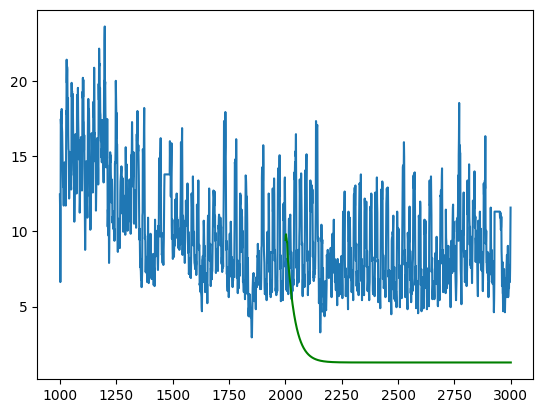

<Figure size 640x480 with 0 Axes>

In [ ]:
print("Future Predictions:", future_predictions)
time = [data_size-m+i for i in range(2*m)]
plt.plot(time, data['HUFL'].values[data_size-m:data_size+m])
#plt.plot(, )
pred = data['HUFL'].values[data_size-1]
time = [data_size+1+i for i in range(m)]

    
plt.plot(time, future_predictions, 'g-')

plt.show()
plt.savefig("forecast", dpi=200)




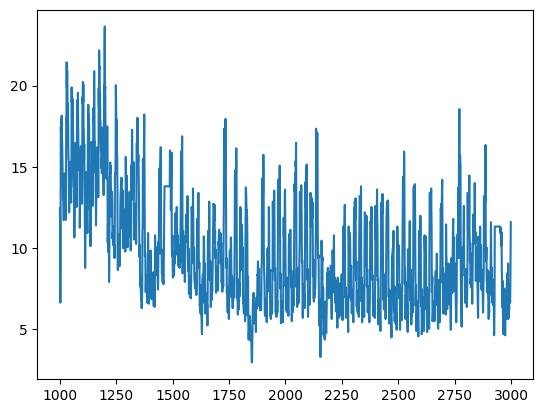

In [ ]:
time = [data_size-m+i for i in range(2*m)]
plt.plot(time, data['HUFL'].values[data_size-m:data_size+m])
plt.show()

In [ ]:
X_f.tolist()

[[6.564000129699707],
 [8.23900032043457],
 [11.854999542236328],
 [10.717000007629395],
 [11.788000106811523],
 [11.854999542236328],
 [10.180999755859375],
 [13.329000473022461],
 [13.597000122070312],
 [11.588000297546387]]